In [8]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [9]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [10]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  75725 - количество слов в словаре
  19855 - количество слов в словаре после фильтрации по min_tf
  19310 - количество слов в словаре после фильтрации по max_tf
   1819 - количество слов в словаре после фильтрации по min_df_rate
   1819 - количество слов в словаре после фильтрации по max_df_rate


In [11]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [12]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [30]:
params = {
    'topic_count': 20,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -4,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

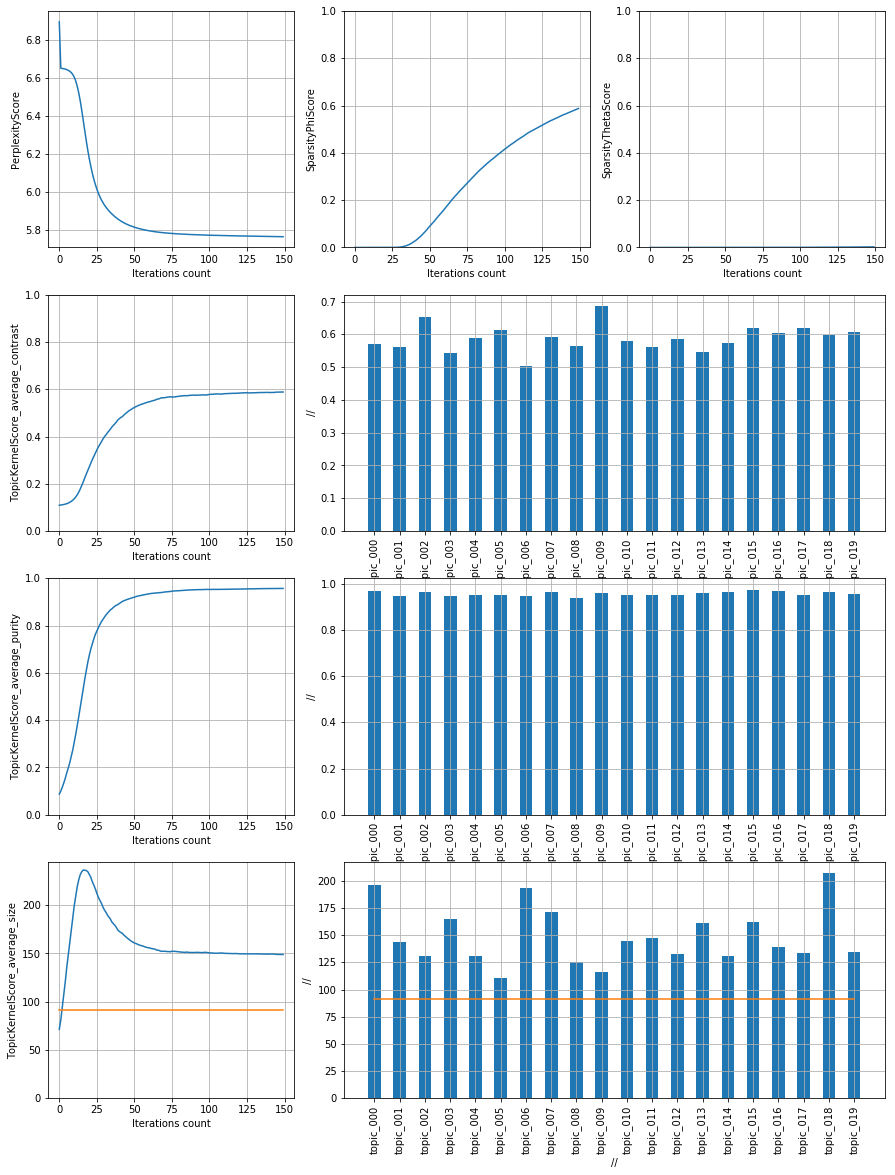

PerplexityScore: 5.762690544128418
SparsityPhiScore: 0.5879329442977905
SparsityThetaScore: 0.0023761996999382973

TopicKernelScore_average_contrast: 0.5883558392524719
TopicKernelScore_average_purity: 0.95726078748703
TopicKernelScore_average_size: 148.85000610351562

TopTokensScore:
topic_000: возможность специалист следовать любой разный иной вывод высокий полный исследование 
topic_001: партия открытый выборы инфо оппозиционер сторонник оштрафовать поддержка твиттер координатор 
topic_002: привлекать руслан прекращать совершенный эпизод обвинительный иван соглашаться преступный доказывать 
topic_003: особо предприятие бизнесмен мошенничество миллион рабочий счет договор банк зарплата 
topic_004: взрыв хранение устройство десять предмет вещество звонок магазин пакет устраивать 
topic_005: отец подросток девочка несовершеннолетний родитель подозревать дочь проводиться пожар детский 
topic_006: видеозапись напоминать обращать читать оглашать зачитывать поддерживать позиция переходить 

In [14]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

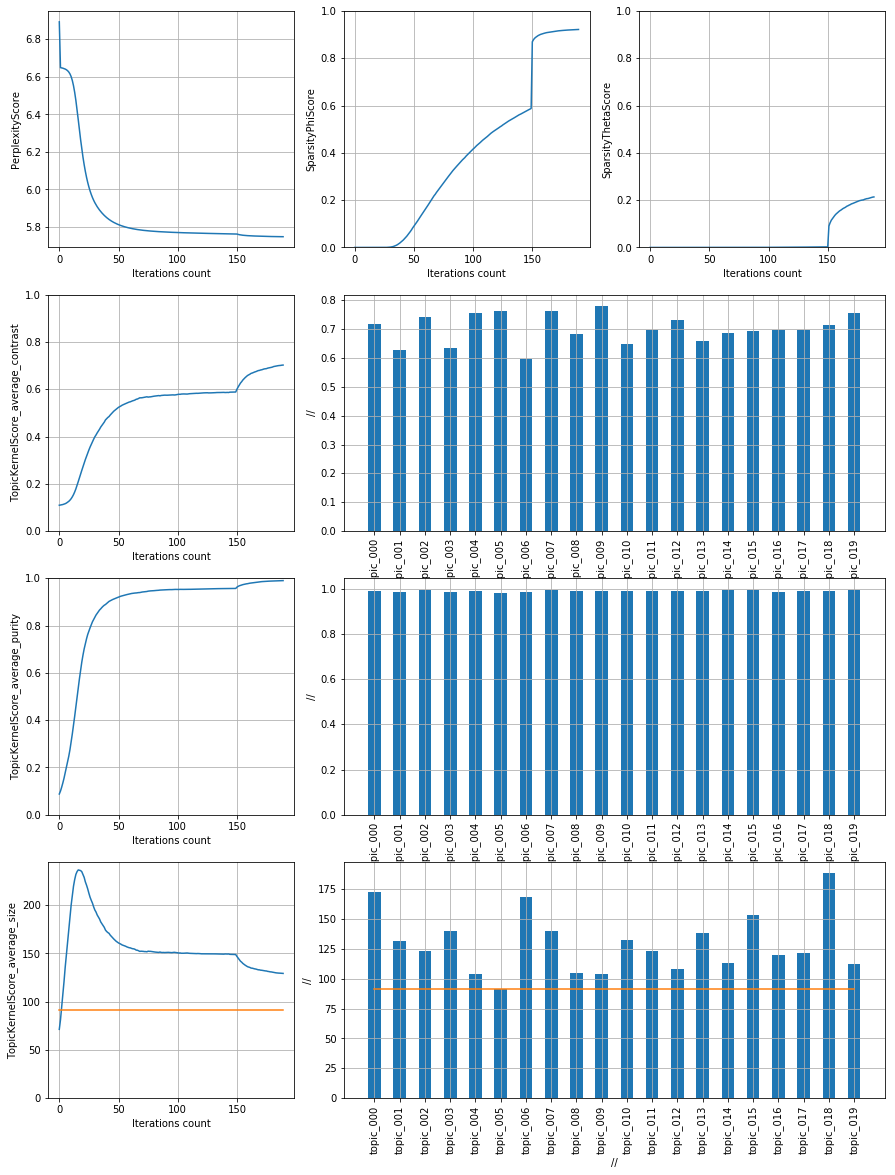

PerplexityScore: 5.748394012451172
SparsityPhiScore: 0.9222649931907654
SparsityThetaScore: 0.2137220799922943

TopicKernelScore_average_contrast: 0.7023552656173706
TopicKernelScore_average_purity: 0.9903692007064819
TopicKernelScore_average_size: 129.3000030517578

TopTokensScore:
topic_000: возможность следовать любой специалист разный иной полный высокий вывод касаться 
topic_001: партия открытый выборы инфо оппозиционер поддержка сторонник оштрафовать твиттер борьба 
topic_002: привлекать прекращать руслан совершенный эпизод обвинительный иван доказывать преступный соглашаться 
topic_003: особо предприятие бизнесмен мошенничество миллион рабочий счет договор банк зарплата 
topic_004: взрыв десять хранение устройство вещество предмет звонок магазин устраивать пакет 
topic_005: отец подросток девочка несовершеннолетний родитель подозревать дочь проводиться пожар детский 
topic_006: видеозапись напоминать обращать поддерживать читать зачитывать оглашать карта осмотр позиция 
topic_00

In [15]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

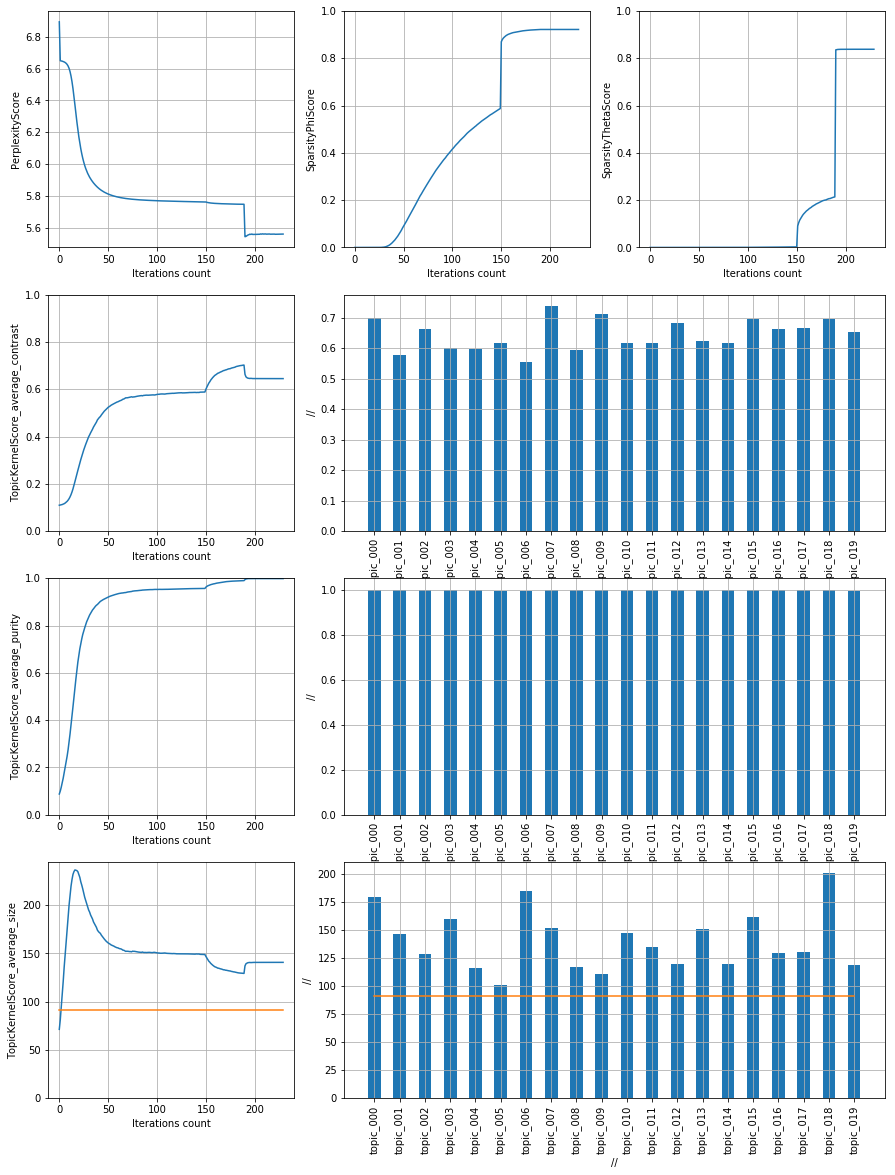

PerplexityScore: 5.561324119567871
SparsityPhiScore: 0.9222924709320068
SparsityThetaScore: 0.838547945022583

TopicKernelScore_average_contrast: 0.6450400352478027
TopicKernelScore_average_purity: 0.9988607168197632
TopicKernelScore_average_size: 140.75

TopTokensScore:
topic_000: возможность следовать высокий иной полный например любой подобный специалист количество 
topic_001: партия выборы оппозиционер открытый инфо волков сторонник координатор пикет твиттер 
topic_002: руслан эпизод привлекать обвинительный доказывать преступный совершенный прекращать иван коллегия 
topic_003: предприятие бизнесмен мошенничество договор особо миллион зарплата счет банк строительство 
topic_004: взрыв устройство вещество звонок хранение магазин взрывной студент десять лагерь 
topic_005: подросток отец девочка родитель дочь несовершеннолетний пожар мальчик детский возраст 
topic_006: читать напоминать зачитывать видеозапись оглашать обращать перерыв переходить осмотр карта 
topic_007: коллега приход

In [16]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

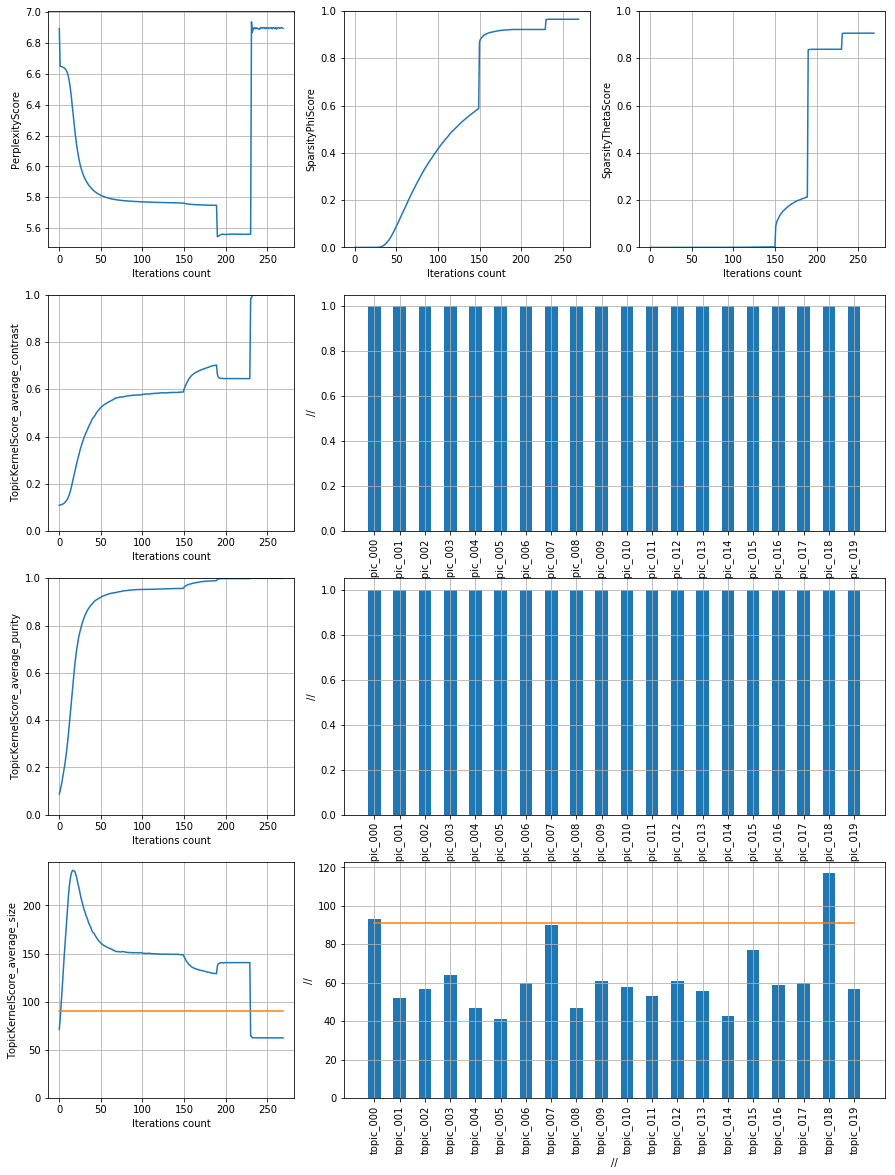

PerplexityScore: 6.895206928253174
SparsityPhiScore: 0.9655579924583435
SparsityThetaScore: 0.9066168069839478

TopicKernelScore_average_contrast: 1.0
TopicKernelScore_average_purity: 1.0
TopicKernelScore_average_size: 62.650001525878906

TopTokensScore:
topic_000: возможность следовать высокий иной полный подобный количество практика важный определять 
topic_001: выборы партия волков инфо оппозиционер открытый сторонник координатор пикет волк 
topic_002: эпизод руслан обвинительный преступный привлекать совершенный вадим коллегия мотив макаров 
topic_003: предприятие бизнесмен договор зарплата банк мошенничество счет миллион особо строительство 
topic_004: взрыв устройство вещество звонок хранение взрывной студент магазин лагерь десять 
topic_005: подросток девочка отец родитель дочь несовершеннолетний мальчик пожар детский возраст 
topic_006: читать зачитывать напоминать оглашать перерыв видеозапись обращать переходить осмотр карта 
topic_007: коллега тюрьма приходиться форма мало за

In [31]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

In [32]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,topic_010,topic_011,topic_012,topic_013,topic_014,topic_015,topic_016,topic_017,topic_018,topic_019
семейный,0.000000,0.000000,0.0,0.000000,0.000000,0.008647,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
жительница,0.000000,0.000000,0.0,0.000000,0.000000,0.019104,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
взыскание,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.012513,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
сокращать,0.000000,0.000000,0.0,0.008661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
вменять,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
объединение,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
памятник,0.000000,0.016074,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
дежурный,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.020863,0.000000,0.000000,0.000000
готовый,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
столкновение,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
theta = model_artm.get_theta()
theta

,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
topic_000,0.075990,0.024447,0.038362,8.905176e-08,2.886946e-02,0.165156,7.216887e-03,0.001596,0.010696,0.021290,...,0.082834,3.551764e-02,1.365293e-04,8.080560e-09,0.051572,4.443438e-02,4.232077e-02,0.048183,0.024571,0.026251
topic_001,0.012298,0.043472,0.025110,5.668910e-04,4.131102e-01,0.003035,1.610601e-02,0.000804,0.080295,0.077834,...,0.082481,3.125498e-02,1.831131e-01,6.660126e-03,0.211526,1.168897e-02,1.225352e-02,0.067279,0.038096,0.237684
topic_002,0.004451,0.134966,0.025210,2.405060e-04,4.449423e-02,0.027489,1.729660e-06,0.159901,0.007458,0.082882,...,0.000003,1.200631e-07,1.046694e-02,9.631616e-03,0.001611,2.965009e-04,4.543743e-02,0.000037,0.014508,0.123607
topic_003,0.008615,0.014062,0.029648,9.387410e-12,9.743783e-03,0.018081,2.706162e-03,0.068831,0.029893,0.001653,...,0.047524,9.533037e-03,1.456504e-03,7.981666e-03,0.007564,3.359050e-02,1.046055e-02,0.166776,0.452676,0.117787
topic_004,0.010933,0.091423,0.020710,1.428571e-01,3.846810e-02,0.054093,8.584396e-02,0.023735,0.005951,0.009630,...,0.004200,2.911499e-02,6.217159e-02,1.459711e-01,0.047601,2.771034e-02,1.892917e-01,0.061460,0.015831,0.024111
topic_005,0.215914,0.004168,0.092591,1.122987e-01,2.981583e-03,0.048894,2.795785e-01,0.085468,0.065809,0.143628,...,0.117878,1.715065e-01,5.232552e-02,4.042830e-02,0.009225,5.591294e-03,8.213264e-02,0.037877,0.012259,0.040103
topic_006,0.045606,0.030078,0.062974,0.000000e+00,9.044671e-02,0.064660,3.901265e-02,0.023747,0.025092,0.028968,...,0.002257,2.323788e-08,1.777327e-09,9.617885e-03,0.026287,1.422220e-08,4.987486e-02,0.015517,0.011757,0.006046
topic_007,0.044350,0.021520,0.068716,5.794987e-02,4.427664e-02,0.195267,6.894775e-03,0.132872,0.087130,0.066092,...,0.008471,1.153359e-02,1.752516e-07,2.341629e-02,0.163736,3.815208e-08,2.342396e-02,0.001113,0.016130,0.034639
topic_008,0.144654,0.021025,0.167565,2.186811e-01,8.893870e-04,0.023330,8.018065e-03,0.004300,0.118939,0.111805,...,0.002272,3.048805e-02,9.520926e-03,1.026875e-02,0.028746,1.168245e-02,4.042730e-03,0.175791,0.017943,0.020371
topic_009,0.043061,0.037438,0.031048,7.143219e-02,2.690730e-03,0.024586,7.766556e-02,0.076354,0.000011,0.004318,...,0.069324,5.786252e-02,9.912472e-02,1.482223e-02,0.065241,3.581713e-03,6.897399e-02,0.007194,0.056187,0.002316


In [35]:
theta[1]

topic_000    0.003951
topic_001    0.085304
topic_002    0.072654
topic_003    0.009365
topic_004    0.027623
topic_005    0.023866
topic_006    0.012552
topic_007    0.061829
topic_008    0.323562
topic_009    0.039190
topic_010    0.013372
topic_011    0.030577
topic_012    0.053739
topic_013    0.011989
topic_014    0.033003
topic_015    0.052925
topic_016    0.036824
topic_017    0.015907
topic_018    0.022744
topic_019    0.069024
Name: 1, dtype: float32